# Flow-Temp Model Test

## Import dependencies and data

In [1]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
#import tensorflow as tf
#from tensorflow.keras import layers

from sklearn.linear_model import Ridge, LinearRegression

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [3]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3]
)

# convert index.date col to datetime
data.index = data.index.set_levels(
    levels=pd.to_datetime(data.index.get_level_values(3).values),
    level=3
)

In [4]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101_default'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT401_GM401'),
    #('setpoints', 'TA01_GT10X_GM10X_default')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [5]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID         
flow          TA01_GP101_default    0
temperatures  TA01_GT10X_GM10X      0
              DC_GT401_GM401        0
dtype: int64





In [6]:
# describe cols
data.describe().transpose()

count         mean         std  min  \
category     sensor_ID                                                    
flow         TA01_GP101_default  166921.0  2354.738858  631.850358  0.0   
temperatures TA01_GT10X_GM10X    166921.0    20.287643    1.043412  0.0   
             DC_GT401_GM401      166921.0    49.677559    3.609970  0.0   

                                    25%     50%     75%     max  
category     sensor_ID                                           
flow         TA01_GP101_default  1864.0  2114.8  2718.4  4206.6  
temperatures TA01_GT10X_GM10X      19.9    20.1    20.5    29.2  
             DC_GT401_GM401        49.0    50.4    51.6    55.9

## Process / transform variables 

In [7]:
# STEPS
fsteps = 20
bsteps = 40

# create forward temp variable, 10 mins
data[('temperatures', 'TA01_GT10X_GM10X_forward')] = data.temperatures.TA01_GT10X_GM10X.shift(periods=-fsteps)

# create first differences (10 steps) f. FORWARD GH temp
data[('temperatures', 'TA01_GT10X_GM10X_fdiff')] = data.temperatures.TA01_GT10X_GM10X_forward.diff(periods=bsteps)

# create first differences (10 steps) f. OUTDOOR temp
data[('temperatures', 'DC_GT401_GM401_diff')] = data.temperatures.DC_GT401_GM401.diff(periods=bsteps)

# create first differences (10 steps) f. DC flow
#data[('flow', 'TA01_GP101_default_fdiff1')] = data.flow.TA01_GP101_default.diff(periods=steps * 1.5)
data[('flow', 'TA01_GP101_default_diff')] = data.flow.TA01_GP101_default.diff(periods=bsteps)
#data[('flow', 'TA01_GP101_default_fdiff3')] = data.flow.TA01_GP101_default.diff(periods=steps // 2)

# get mixed effects
data[('mixed', 'temp_flow')] = data.flow.TA01_GP101_default * data.temperatures.DC_GT401_GM401
data[('mixed', 'temp_flow_diff1')] = data.mixed.temp_flow.diff(periods=bsteps)
# data[('mixed', 'temp_flow_diff2')] = data.temperatures.DC_GT401_GM401 * data.flow.TA01_GP101_default_diff
# data[('mixed', 'temp_flow_diff3')] = data.temperatures.DC_GT401_GM401_diff * data.flow.TA01_GP101_default
data[('mixed', 'temp_flow2')] = data.flow.TA01_GP101_default / data.flow.TA01_GP101_default.max() \
                                * data.temperatures.DC_GT401_GM401 / data.temperatures.DC_GT401_GM401.max()


# crop dataset
data = data.iloc[bsteps:-fsteps].copy()

### Plot pairwise correlation matrix

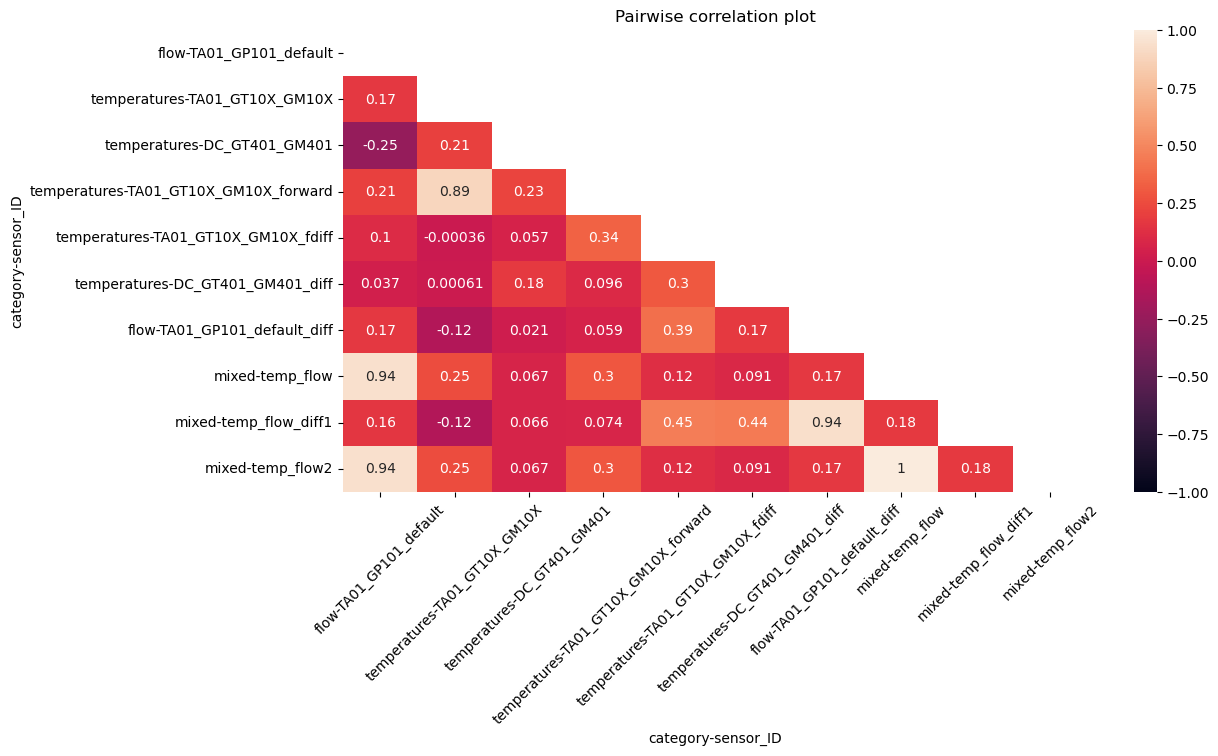

In [8]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 6))
sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, annot=True)

plt.xticks(rotation=45)
plt.title('Pairwise correlation plot')
plt.show()

# delete correlation data
del corr

## Preparing data

### Data selection and whitening

In [9]:
# Define model variables
model_vars = [
    ('temperatures', 'TA01_GT10X_GM10X_fdiff'),
    ('temperatures', 'DC_GT401_GM401_diff'),
    ('flow', 'TA01_GP101_default_diff'),
#     ('mixed', 'temp_flow'),
    ('mixed', 'temp_flow_diff1'),
#     ('mixed', 'temp_flow_diff2'),
#     ('mixed', 'temp_flow_diff3'),
    ('mixed', 'temp_flow2'),
]

# filter data
data = data[model_vars]

In [10]:
# normalize all columns
for col in data.columns:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

### Create sequences

In [11]:
# N step range
n_steps = bsteps + fsteps

# get flagged dates
data['day'] = data.index.get_level_values(1).values
data['date_flag'] = data.day - data.day.shift(periods=n_steps) > 1

# remove erroneous rows
data = data[data.date_flag == 0]

# delete cols
del data['day'], data['date_flag']

In [12]:
# get X, Y
Y = data.pop(('temperatures', 'TA01_GT10X_GM10X_fdiff')).values
X = data.values

# save X, targets for testing
X, examp_X  = X[:-8640], X[-8640:]
Y, examp_Y  = Y[:-8640], Y[-8640:]

# delete data
#del data

### Shuffle and split dataset

In [13]:
# get random indices
idxs = np.arange(len(X))
np.random.shuffle(idxs)

# shuffle sequences and targets
X = np.squeeze(X[idxs])
Y = np.squeeze(Y[idxs])

In [14]:
# split data
train_n = int(len(X) * 0.8)
#test_n = len(targets) - train_n

X_train, X_test = X[:train_n], X[train_n:]
Y_train, Y_test = Y[:train_n], Y[train_n:]

In [15]:
# delete vars
del X, Y

## Deploy RIDGE model

In [16]:
model = Ridge(
    alpha=1.0,
    fit_intercept=False
)

C = model.fit(X_train, Y_train)
C.coef_

array([ 0.10887257, -0.02880924,  0.43383324,  0.04624994])

In [17]:
Y_preds = model.predict(X_test)
np.corrcoef(Y_preds, Y_test)

array([[1.        , 0.45471505],
       [0.45471505, 1.        ]])

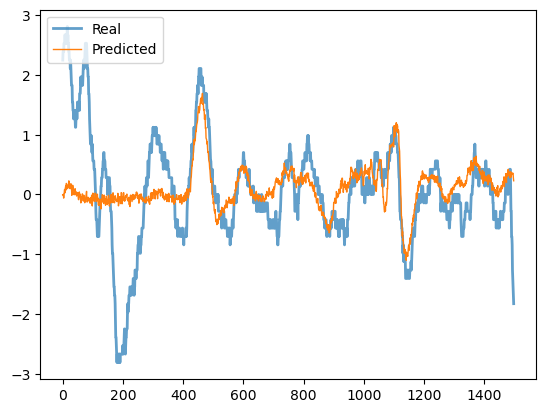

In [20]:
examp_preds = model.predict(examp_X)

plt.plot(examp_Y[-1500:-1], linewidth=2.0, alpha=0.7, label='Real')
plt.plot(examp_preds[-1500:-1], linewidth=1.0, alpha=1.0, label='Predicted')

plt.legend(loc='upper left')
plt.show()